Дорогой студент!

В данном домашнем задании предоставляется возможность поработать с задачей по распознаванию позитивных и негативных отзывы людей по автомобилю Tesla. База для обучения содержит два текстовых файла с рядом строчных отзывов с мнением людей об автомобиле Tesla, соответственно негативного и позитивного содержания. Ссылка на скачивание базы уже включена в ноутбук задания.


Необходимо выполнить следующие действия:

  1. Загрузите саму базу по ссылке и подговьте файлы базы для обработки.
  2. Создайте обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети в 85-90% на проверочной выборке.
   


**Импорт библиотек, загрузка базы и подготовка её к предобработке.**

In [ ]:
# Работа с массивами данных
# Для работы с файлами в Colaboratory
import os

# Загрузка датасетов из облака google
import gdown
# Отрисовка графиков
# Отрисовка графиков
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Основные слои
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

%matplotlib inline


Функция download_and_extract скачивает архив с данными по указанной URL-ссылке, 
распаковывает его в указанную директорию и удаляет архив после распаковки.

In [ ]:
def download_and_extract(url, output_dir):
    """Скачивает и распаковывает архив с датасетом"""
    # Создаем папку для данных, если ее нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Путь для сохранения архива
    zip_path = os.path.join(output_dir, 'dataset.zip')
    
    # Скачиваем архив
    print("Скачивание архива...")
    gdown.download(url, zip_path, quiet=False)
    
    # Распаковываем архив
    print("Распаковка архива...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    
    # Удаляем архив
    os.remove(zip_path)
    print("Датасет готов к использованию")

In [ ]:
# Загрузка и распаковка архива
download_and_extract('https://storage.yandexcloud.net/aiueducation/Content/base/l7/tesla.zip', 'tesla')

**Загрузка текста из файлов, преобразование в одну строку.**

Функция read_text читает содержимое текстового файла, заменя переносы строк на пробелы,
и возвращает полученный текст.

In [4]:
# Объявляем функции для чтения файла. На вход отправляем путь к файлу
def read_text(file_name):

  # Задаем открытие нужного файла в режиме чтения
  read_file = open(file_name, 'r')

  # Читаем текст
  text = read_file.read()

  # Переносы строки переводим в пробелы
  text = text.replace("\n", " ")

  # Возвращаем текст файла
  return text

# Объявляем интересующие нас классы
class_names = ["Негативный отзыв", "Позитивный отзыв"]

# Считаем количество классов
num_classes = len(class_names)

**Тексты в один список.**

Здесь мы загружаем все текстовые файлы из папки 'tesla' в список texts_list.

In [ ]:
# Создаём список под тексты для обучающей выборки
texts_list = []

# Циклом проводим итерацию по текстовым файлам в папке отзывов
for j in os.listdir('tesla/'):

  # Добавляем каждый файл в общий список для выборки
        texts_list.append(read_text('tesla/' + j))

        # Выводим на экран сообщение о добавлении файла
        print(j, 'добавлен в обучающую выборку')

Негативный отзыв.txt добавлен в обучающую выборку
Позитивный отзыв.txt добавлен в обучающую выборку


Здесь мы анализируем длину каждого текста в символах.

In [7]:
# Узнаем объём каждого текста в словах и символах
texts_len = [len(text) for text in texts_list]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Выводим на экран  информационное сообщение
print(f'Размеры текстов по порядку (в токенах):')

# Циклом проводим итерацию по списку с объёмами текстов
for text_len in texts_len:

  # Запускаем "счётчик" номера текста
  t_num += 1

  # Выводим на экран сообщение о номере и объёме текста
  print(f'Текст №{t_num}: {text_len}')

Размеры текстов по порядку (в токенах):
Текст №1: 134535
Текст №2: 213381


Далее рассчитаем, сколько символов составит 80% объёма каждого текста, чтобы по полученному индексу отделить эти 80% на обучающую и оставшиеся 20% на проверочную выборку. Эти значения необходимы для подготовки деления на выборки слайсингом по индексу.

In [8]:
# Создаём список с вложенным циклом по длинам текстов, где i - 100% текста, i/5 - 20% текста
train_len_shares = [(i - round(i/5)) for i in texts_len]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Циклом проводим итерацию по списку с объёмами текстов равными 80% от исходных
for train_len_share in train_len_shares:

  # Запускаем "счётчик" номера текста
  t_num += 1

  # Выводим на экран сообщение о номере и объёме текста в 80% от исходного
  print(f'Доля 80% от текста №{t_num}: {train_len_share} символов')

Доля 80% от текста №1: 107628 символов
Доля 80% от текста №2: 170705 символов


Импортируем функцию **chain()** для добавления текстов в каждую выборку.

---
 Дополнительная информация: ([База знаний УИИ  - **"Методы работы со списками: функция chain( )**"](https://colab.research.google.com/drive/1KJKg_WYD8Vq63cciOMBEEAhFpyPv0A0V?usp=sharing/))

---

Производём нарезку (метод слайсинга) по полученному ранее индексу для формирования текстов отдельно для обучающей(80%) и проверочной(20%) выборок:

In [ ]:
text_train = []
text_validate = []
# Ваше решение
for i, text in enumerate(texts_list):
    text_train.append(text[:train_len_shares[i]])
    text_validate.append(text[train_len_shares[i]:])


VOCAB_SIZE = 20000
WIN_SIZE = 1000
WIN_HOPE = 150

1. split_sequence - разбивает последовательность на отрезки скользящим окном
2. vectorize_sequence - преобразует последовательности в векторы и создает метки классов

In [10]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

1. Создаем токенизатор и обучаем его на всех текстах
2. Преобразуем тексты в последовательности индексов
3. Создаем обучающую и тестовую выборки
4. Преобразуем последовательности в матрицы и анализируем баланс классов

In [11]:
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True,
    split=" ",
    oov_token="неизвестное_слово",
    char_level=False,
)
tokenizer.fit_on_texts(texts_list)
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_validate)
# Формирование обучающей выборки
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOPE)
# Формирование тестовой выборки
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOPE)
x_train = tokenizer.sequences_to_matrix(x_train.tolist()).astype("float16")
x_test = tokenizer.sequences_to_matrix(x_test.tolist()).astype("float16")
# Преобразуем one-hot обратно в метки классов
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

# Подсчёт с помощью bincount
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Вывод результатов
print("Обучающая выборка:")
for cls, count in enumerate(train_counts):
    print(f"Класс {cls}: {count} окон")

print("\nТестовая выборка:")
for cls, count in enumerate(test_counts):
    print(f"Класс {cls}: {count} окон")

Обучающая выборка:
Класс 0: 107 окон
Класс 1: 166 окон

Тестовая выборка:
Класс 0: 23 окон
Класс 1: 38 окон


1. Создаем последовательную модель с несколькими полносвязными слоями
2. Добавляем Dropout для борьбы с переобучением
3. Компилируем модель с оптимизатором Adam
4. Обучаем модель на GPU

In [ ]:
model = Sequential(
    [
        Input((VOCAB_SIZE,)),
        # BatchNormalization(),
        Dense(200, activation="relu"),
        Dropout(0.4),
        Dense(100),
        Dropout(0.4),
        # BatchNormalization(),
        Dense(2, activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

# Автоматическое использование GPU
with tf.device('/GPU:0'):
    history = model.fit(
        x_train,
        y_train,
        epochs=150,
        batch_size=16,
        validation_data=(x_test, y_test),
        verbose=1,
    )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 200)            │     4,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,020,502 (15.34 MB)

 Trainable params: 4,020,502 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7871 - loss: 0.3139 - val_accuracy: 0.9344 - val_loss: 0.1432
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 1.5014e-05 - val_accuracy: 0.9016 - val_loss: 0.2365
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.2666e-05 - val_accuracy: 0.9016 - val_loss: 0.2266
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 7.5232e-07 - val_accuracy: 0.9180 - val_loss: 0.1889
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.1513e-06 - val_accuracy: 0.9344 - val_loss: 0.1772
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 1.5994e-06 - val_accuracy: 0.9344 - val_loss: 0.1647
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 2.2739e-06 - val_accuracy: 0.9344 - val_loss: 0.1485
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3

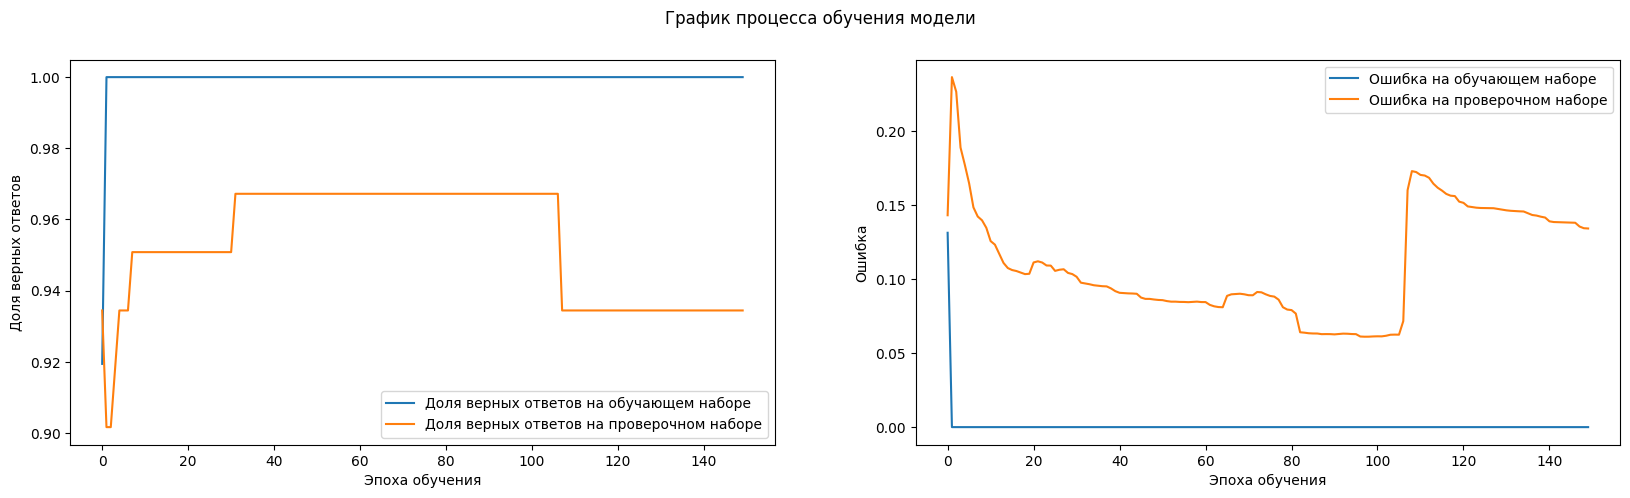

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели")
ax1.plot(
    history.history["accuracy"], label="Доля верных ответов на обучающем наборе"
)
ax1.plot(
    history.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()

Выводим итоговую точность модели на тестовых данных.

In [17]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=175)

print(f'Test Accuracy: {accuracy:.2%}')

Test Accuracy: 93.44%
